In [20]:
import importlib

import ipynb.fs.full.preprocessing0
import ipynb.fs.full.preprocessing05
#import ipynb.fs.full.prepossessing075_akistage
import preprocessing1
#import ipynb.fs.full.preprocessing2_BT
import preprocessing2_BT

import ipynb.fs.full.preprocessing25_BTcorr
import ipynb.fs.full.preprocessing3_smote
#import ipynb.fs.full.preprocessing4
import preprocessing4

#import ipynb.fs.full.runxgboost
import runxgboost

#import ipynb.fs.full.postprocessing1_SHAP

import postprocessing1_SHAP

import ipynb.fs.full.postprocessing3_collect

from ipynb.fs.full.slackbot import ping_slack
import pandas as pd
import xgboost as xgb
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import BSpline, make_interp_spline, interp1d
#import rpy2.robjects as robjects
#from rpy2.robjects.packages import importr
import csv
from dfply import *
from xgboost import XGBClassifier
import itertools
import os
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from os.path import exists
import logging
import time

import utils_function
import seaborn as sns
from scipy import stats

import plot_utils
import pickle

import utils_code2name

In [21]:
importlib.reload(ipynb.fs.full.preprocessing0)
importlib.reload(ipynb.fs.full.preprocessing05)
#importlib.reload(ipynb.fs.full.prepossessing075_akistage)
importlib.reload(preprocessing1)
importlib.reload(preprocessing2_BT)
importlib.reload(ipynb.fs.full.preprocessing25_BTcorr)
importlib.reload(ipynb.fs.full.preprocessing3_smote)
# #importlib.reload(ipynb.fs.full.preprocessing4)
importlib.reload(preprocessing4)
importlib.reload(runxgboost)
importlib.reload(postprocessing1_SHAP)
importlib.reload(ipynb.fs.full.postprocessing3_collect)
importlib.reload(postprocessing1_SHAP)
importlib.reload(utils_function)
importlib.reload(plot_utils)
importlib.reload(utils_code2name)

<module 'utils_code2name' from '/home/hoyinchan/code/AKI_CDM_PY/utils_code2name.py'>

In [22]:
site_list = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'UTHSCSA', 'UNMC']
configs_variables = [utils_function.read_config(site) for site in site_list]

In [23]:
plot_utils.geb_top_top(configs_variables)

In [24]:
site, datafolder, home_directory = utils_function.get_commons(configs_variables[0])

In [25]:
''' 
statistics
'''
onset_counts = list()
sumv = 0
sump = 0
#for site in site_list:
for site in site_list:
    onset = pd.read_parquet(datafolder+site+'/p0_onset_'+site+'.parquet')
    onset = onset.drop_duplicates()
    onset_count = onset[['ENCOUNTERID', 'AKI_STAGE']].groupby('AKI_STAGE').count()/onset.shape[0]
    sump += onset[['PATID']].drop_duplicates().shape[0]
    sumv += onset.shape[0]
    onset_count.columns = [site]
    onset_counts.append(onset_count)
onset_count = np.round(pd.concat(onset_counts,axis=1).T,2)


In [26]:
'''
Collect cross_validationr results
'''
shap_datas = plot_utils.collect_cross_cv(configs_variables)

In [27]:
#Avg model transportability
shap_datas_ext = shap_datas[shap_datas['site_m']!=  shap_datas['site_d']].groupby('site_m').mean().reset_index()
shap_datas_in = shap_datas[shap_datas['site_m']==  shap_datas['site_d']].groupby('site_m').mean().reset_index()

In [28]:
# shap_datas_ext.rename({'roc':'roc_ext','prauc':'prauc_ext'}, inplace=True)
# shap_datas_ext.rename({'roc':'roc_in','prauc':'prauc_in'}, inplace=True)
shap_datasx = shap_datas_ext.merge(shap_datas_in,on='site_m',how='inner')
shap_datasx['trans'] = shap_datasx['roc_x']/shap_datasx['roc_y']
shap_datasx

,site_m,fold_x,roc_x,prauc_x,fold_y,roc_y,prauc_y,trans
0,KUMC,4.5,0.747407,0.379187,4.5,0.856469,0.597401,0.872661
1,MCW,4.5,0.758343,0.405678,4.5,0.851386,0.588479,0.890716
2,UIOWA,4.5,0.754063,0.400831,4.5,0.850566,0.580595,0.886543
3,UMHC,4.5,0.737198,0.361635,4.5,0.867666,0.641658,0.849634
4,UNMC,4.5,0.757761,0.394830,4.5,0.847810,0.602435,0.893787
5,UPITT,4.5,0.740169,0.383554,4.5,0.808873,0.512726,0.915062
6,UTHSCSA,4.5,0.733709,0.341835,4.5,0.790728,0.507853,0.927890
7,UTSW,4.5,0.766728,0.407100,4.5,0.851811,0.598589,0.900116
8,UofU,4.5,0.724433,0.359775,4.5,0.876325,0.620809,0.826672


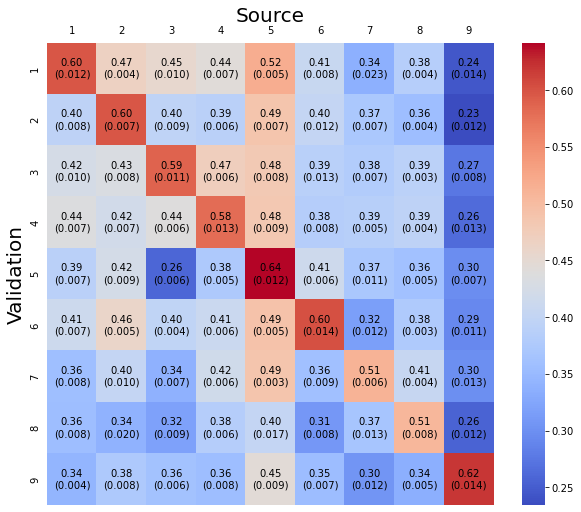

In [29]:
plot_utils.headmap(shap_datas, target='prauc', site_ano=True)

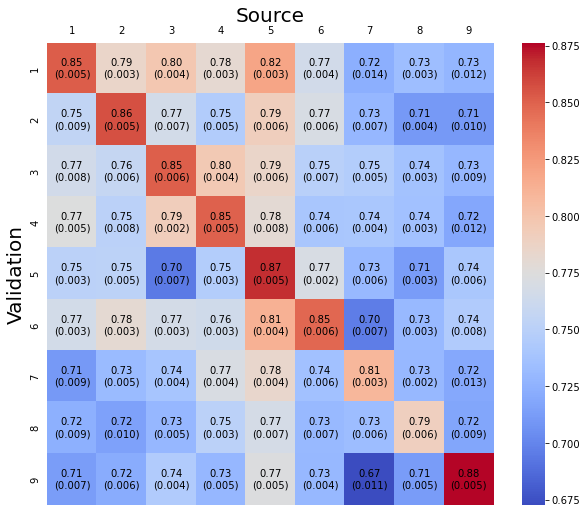

In [30]:
plot_utils.headmap(shap_datas, site_ano=True)

In [31]:
#plot_utils.create_radar_chart_with_confidence(shap_datas, site_ano=True)

In [32]:
#plot_utils.create_radar_chart_with_confidence(shap_datas, target='prauc', site_ano=True)

In [33]:
importlib.reload(plot_utils)

df_importances, df_importances_stat = plot_utils.get_importances_features_stat(configs_variables)

In [34]:
code_translator = utils_code2name.code2name()
#code_translator.load_concept()
#omop_label = {x:code_translator.translate_omop(x) for x in df_importances_stat[df_importances_stat['Label_rank']!=-100].index}
#omop_label = {x:code_translator.custom_translate_omop_2022(x) for x in df_importances_stat[df_importances_stat['Label_rank']!=-100].index}

In [35]:
df_importances_stat[['PX:' in x for x in df_importances_stat.index]].sort_values('Median')

,Median,IQR,Count,Label_rank
Feature Id no unit,,,,
PX:CH:J7050,0.0100,0.00000,1,-100.0
PX:CH:74018,0.0200,0.00000,1,-100.0
PX:OT:BB000,0.0300,0.00000,1,-100.0
PX:CH:36592,0.0350,0.00000,1,-100.0
PX:CH:74177,0.0400,0.00000,1,-100.0
...,...,...,...,...
PX:09:96.72,0.8050,0.00000,1,-4.0
PX:CH:J3490,0.8100,0.00000,1,-3.0
PX:CH:A6257,0.8650,0.00000,1,-2.0


In [36]:
df_importances_stat.to_pickle('Fig2_plot_feature_importance_data.pkl')

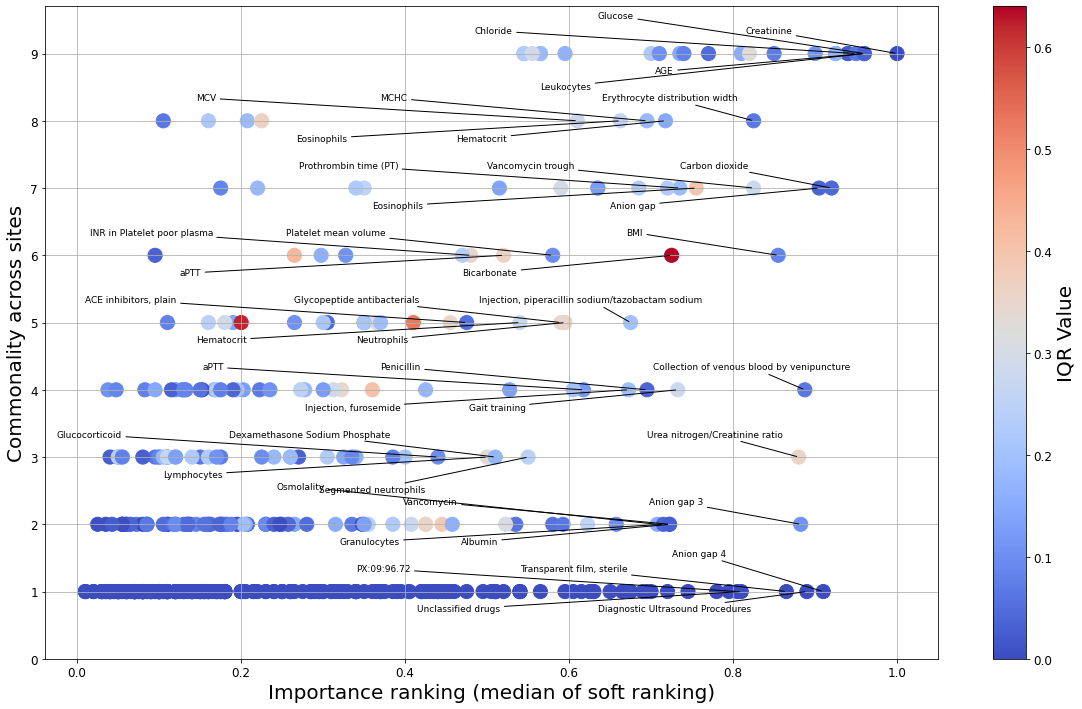

In [53]:
importlib.reload(plot_utils)
importlib.reload(utils_code2name)
code_translator = utils_code2name.code2name()
include_list=['PX:CH:J2543', 'PX:CH:36415']
modify_list=['LAB::LG7967-5', 'MED:ATC:B01AB', 'LAB::LG32857-1', 'LAB::LG50024-5', 'LAB::26505-8', 'LAB::18182-6', 'LAB::LG6139-2']
#modify_list = ['LAB::LG50024-5', 'LAB::LG1962-0']

plot_utils.plot_feature_importance(df_importances_stat, code_translator.custom_translate_omop_2022_2_no_lonic, modify_list, include_list)

In [49]:
extracted_data = {
    'LAB::LG6657-3': 'Creatinine (LAB:LONIC:LG6657-3)',
    'LAB::48642-3': 'Glomerular filtration rate predicted among non-blacks (LAB:LONIC:48642-3)',}
extracted_data.get('LAB::LG6657-3', 'LAB::LG6657-3').rsplit(" ", 1)[0]

'Creatinine'

In [38]:
#omop_label = {x:code_translator.translate_omop(x) for x in df['Feature Id no unit'].unique()}

df = df_importances.sort_values('rank', ascending=False).reset_index().groupby('site').head(10)
df['Feature Id'] = [code_translator.custom_translate_omop_2022_2(x) for x in df['Feature Id no unit']]
df = df[['Feature Id', 'site', 'rank']]
df = df.sort_values(by=['site', 'rank'], ascending=[True, False])
df['rank2'] = df.groupby('site').cumcount() + 1
df_pivot = df.pivot(index='site', columns='rank2', values='Feature Id')

df_pivot

rank2,1,2,3,4,5,6,7,8,9,10
site,,,,,,,,,,
KUMC,Creatinine (LAB:LONIC:LG6657-3),Bicarbonate (LAB:LONIC:LG2807-8),Leukocytes (LAB:LONIC:LG32857-1),Calcium (LAB:LONIC:LG49864-8),Chloride (LAB:LONIC:LG6373-7),AGE,Glucose (LAB:LONIC:LG7967-5),Urea nitrogen (LAB:LONIC:LG1314-6),SYSTOLIC,Anion gap (LAB:LONIC:LG13614-9)
MCW,Creatinine (LAB:LONIC:LG6657-3),Collection of venous blood by venipuncture (PX...,Leukocytes (LAB:LONIC:LG32857-1),Glucose (LAB:LONIC:LG7967-5),AGE,Chloride (LAB:LONIC:LG6373-7),Bicarbonate (LAB:LONIC:LG2807-8),Urea nitrogen (LAB:LONIC:LG1314-6),Calcium (LAB:LONIC:LG49864-8),Anion gap (LAB:LONIC:LG13614-9)
UIOWA,Creatinine (LAB:LONIC:LG6657-3),Leukocytes (LAB:LONIC:LG32857-1),Carbon dioxide (LAB:LONIC:LG4454-7),Glucose (LAB:LONIC:LG7967-5),Potassium (LAB:LONIC:LG49936-4),SYSTOLIC,AGE,Urea nitrogen (LAB:LONIC:LG1314-6),Chloride (LAB:LONIC:LG6373-7),BMI
UMHC,Creatinine (LAB:LONIC:LG6657-3),AGE,SYSTOLIC,Carbon dioxide (LAB:LONIC:LG4454-7),Lymphocytes (LAB:LONIC:736-9),Calcium (LAB:LONIC:LG49864-8),Potassium (LAB:LONIC:LG49936-4),Glucose (LAB:LONIC:LG7967-5),DIASTOLIC,Anion gap 4 (LAB:LONIC:LG6139-2)
UNMC,Creatinine (LAB:LONIC:LG6657-3),Urea nitrogen (LAB:LONIC:LG1314-6),AGE,SYSTOLIC,Glucose (LAB:LONIC:LG7967-5),Anion gap (LAB:LONIC:LG13614-9),Calcium (LAB:LONIC:LG49864-8),Carbon dioxide (LAB:LONIC:LG4454-7),DIASTOLIC,Lymphocytes (LAB:LONIC:26478-8)
UPITT,Creatinine (LAB:LONIC:LG6657-3),DIASTOLIC,SYSTOLIC,Chloride (LAB:LONIC:LG6373-7),AGE,Potassium (LAB:LONIC:LG49936-4),BMI,Eosinophils (LAB:LONIC:713-8),Bicarbonate (LAB:LONIC:LG2807-8),Carbon dioxide (LAB:LONIC:LG4454-7)
UTHSCSA,Creatinine (LAB:LONIC:LG6657-3),Leukocytes (LAB:LONIC:LG32857-1),Glucose (LAB:LONIC:LG7967-5),Urea nitrogen (LAB:LONIC:LG1314-6),AGE,Calcium (LAB:LONIC:LG49864-8),Phosphate (LAB:LONIC:LG49949-7),Potassium (LAB:LONIC:LG49936-4),SYSTOLIC,DIASTOLIC
UTSW,Creatinine (LAB:LONIC:LG6657-3),Anion gap 3 (LAB:LONIC:10466-1),Calcium (LAB:LONIC:LG49864-8),Urea nitrogen (LAB:LONIC:LG1314-6),Glucose (LAB:LONIC:LG7967-5),Chloride (LAB:LONIC:LG6373-7),Potassium (LAB:LONIC:LG49936-4),Lymphocytes (LAB:LONIC:736-9),AGE,Carbon dioxide (LAB:LONIC:LG4454-7)
UofU,Creatinine (LAB:LONIC:LG6657-3),Urea nitrogen (LAB:LONIC:LG1314-6),Glucose (LAB:LONIC:LG7967-5),AGE,Leukocytes (LAB:LONIC:LG32857-1),Chloride (LAB:LONIC:LG6373-7),Platelets (LAB:LONIC:LG32892-8),Calcium (LAB:LONIC:LG49864-8),Carbon dioxide (LAB:LONIC:LG4454-7),Potassium (LAB:LONIC:LG49936-4)


In [39]:
#df_importances[df_importances['Feature Id no unit']=='LAB::LG32850-6']

In [40]:
importlib.reload(plot_utils)

df_importances, df_importances_stat = plot_utils.get_importances_features_stat(configs_variables)
external_heatmap_df = pd.read_csv('r2svg.csv').drop('Unnamed: 0',axis=1)

In [41]:
df_importances

,Feature Id no unit,site,Feature Id,rank
0,AGE,KUMC,AGE,0.955
1,AGE,MCW,AGE,0.950
2,AGE,UIOWA,AGE,0.940
3,AGE,UMHC,AGE,0.990
4,AGE,UNMC,AGE,0.980
...,...,...,...,...
1170,SYSTOLIC,UNMC,SYSTOLIC,0.970
1171,SYSTOLIC,UPITT,SYSTOLIC,0.980
1172,SYSTOLIC,UTHSCSA,SYSTOLIC,0.925
1173,SYSTOLIC,UTSW,SYSTOLIC,0.100


Index(['Median', 'IQR', 'Count', 'Label_rank', 'cusheight', 'Feature Id',
       'r.sq_spline_AUC', 'slope_auc', 'heap', 'Feature Id no unit'],
      dtype='object')


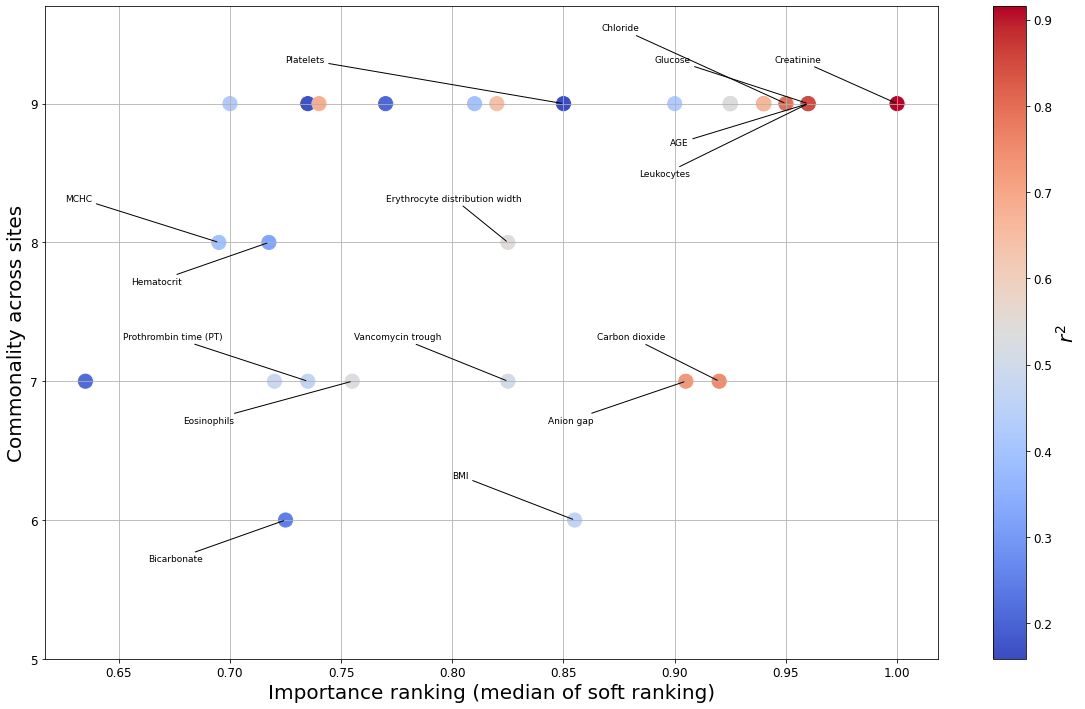

In [54]:
importlib.reload(plot_utils)
include_list=['LAB::LG32892-8', 'AGE', 'LAB::LG4454-7']
modify_list=['LAB::LG6373-7', 'LAB::1962-0', 'MED:ATC:B01AB', 'LAB::LG32857-1', 'LAB::LG50024-5', 'LAB::26505-8', 'LAB::18182-6', 'LAB::LG6139-2']
plot_utils.plot_feature_importancer2(df_importances_stat, external_heatmap_df, code_translator.custom_translate_omop_2022_2_no_lonic, modify_list, include_list)